In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import tqdm
import scipy
import pickle
import numpy as np
import ase.io as aio
import seaborn as sns
from toolz.curried import pipe, curry, compose

import torch

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
from ipywidgets import interact

In [5]:
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
from skimage import data, img_as_float

from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

In [6]:
import skimage.feature as features
import skimage.morphology as morph
import skimage.segmentation as seg
import scipy.ndimage.filters as spy_filters
import skimage.filters as skm_filters

In [7]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 24
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [8]:
import utilities as utils

In [9]:
@curry
def thresh(im, h):
    return im > h

@curry
def get_peak_coords(data, size=5, threshold=0.8):

    data_max = max_filter(size=size)(data)
    maxima = (data == data_max)
    data_min = min_filter(size=size)(data)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = int(np.round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(np.round((dy.start + dy.stop - 1)/2))    
        y.append(y_center)
        
    return x, y

@curry
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w//2), int(h//2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

bool_to_int = lambda x: x*1

to_log = lambda x: np.log10(x)

In [10]:
## Filters
sobel = curry(skm_filters.sobel)
blur = curry(skm_filters.gaussian)
erode = curry(morph.binary_erosion)
opening = curry(morph.binary_opening)
max_filter = curry(ndimage.maximum_filter)
min_filter = curry(ndimage.minimum_filter)

In [11]:
slicer = utils.return_slice(cutoff=350, s=None)

In [12]:
runs = np.loadtxt("runs.txt").astype(int)
folder_saed = "data/saeds_1024"

image shape: (1025, 1025)


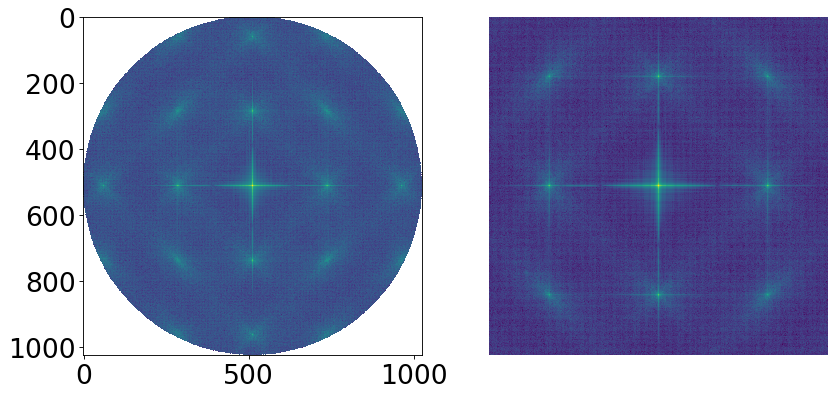

In [13]:
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])
img = utils.load_file(f_saed)
img_log = np.log10(img)

print("image shape: {}".format(img.shape))

    
fig, axs = plt.subplots(1, 2, figsize=[12, 6])
axs[0].imshow(img_log)
axs[1].imshow(slicer(img_log))
for idx, ax in enumerate(fig.get_axes()):
    ax.label_outer()
    if idx > 0:
        ax.axis('off')

## Approach 1

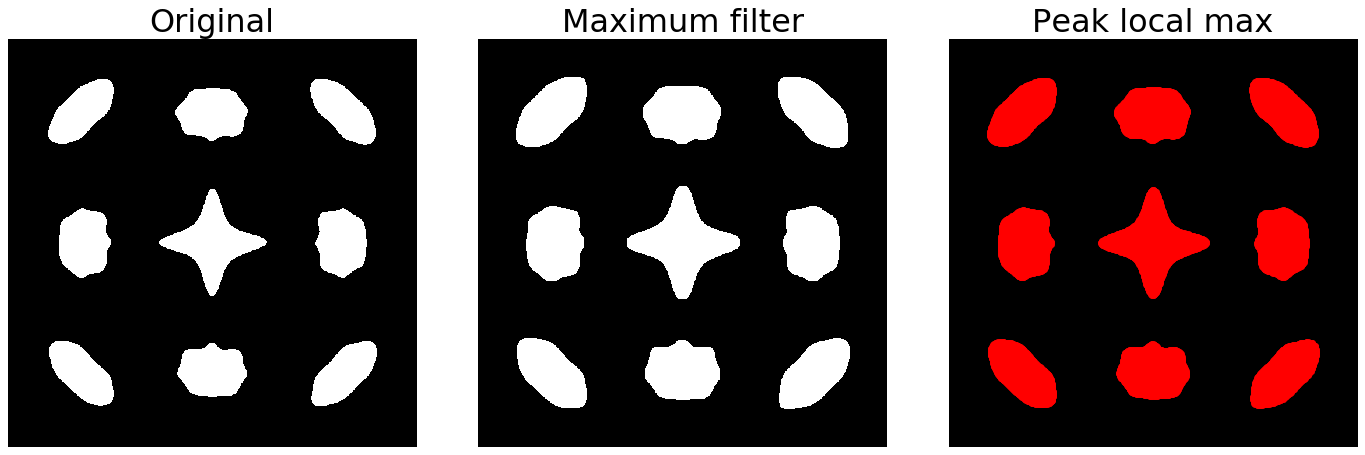

In [14]:
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])
img = utils.load_file(f_saed)
img_log = np.log10(img)

img = compose(thresh(h=0.6), blur(sigma=10), slicer)(img_log)

r = 10
image_max = ndimage.maximum_filter(img, size=r, mode='constant')
coordinates = peak_local_max(img, min_distance=r, threshold_rel=0.80)

# display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(img, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()
plt.show()

## Approach 2

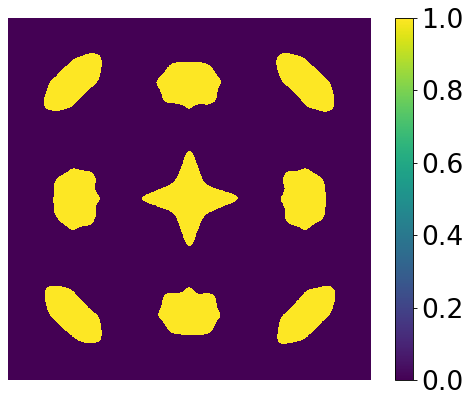

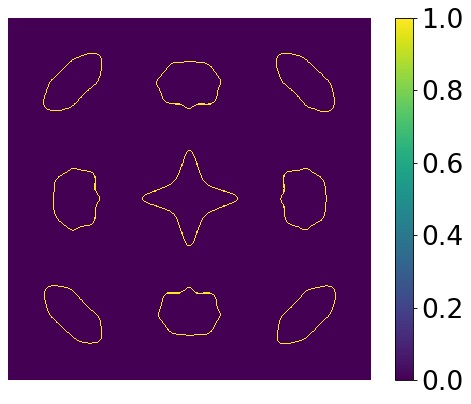

In [15]:
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])
img = utils.load_file(f_saed)
img_log = np.log10(img)


img_bw = compose(thresh(h=0.6), blur(sigma=10), slicer)(img_log)
img_ed = compose(sobel)(img_bw)
utils.draw_im(img_bw*1)
utils.draw_im((img_ed>0.5)*1)

## Approach 3

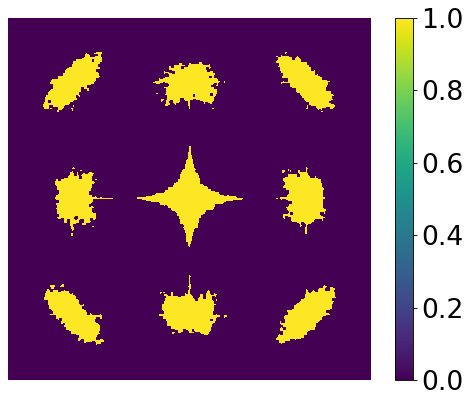

In [16]:
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])
img = utils.load_file(f_saed)
img_log = np.log10(img)

img_bw = compose(thresh(h=0.5), blur, slicer)(img_log)
transform = compose(curry(morph.binary_opening), erode(selem=np.ones((5,5))))
utils.draw_im(transform(img_bw)*1)

## Approach 4

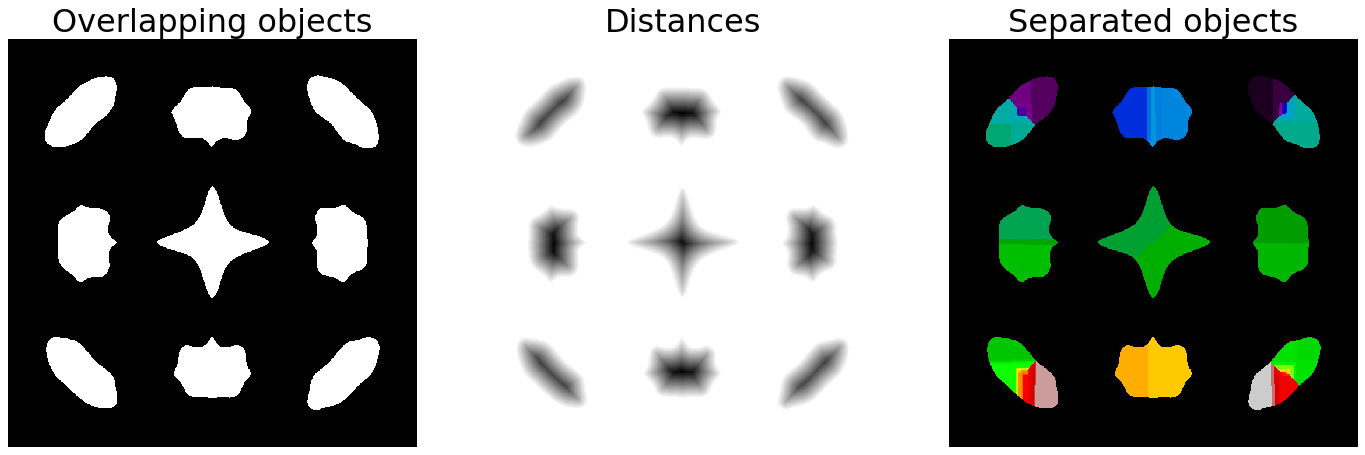

In [25]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])
img = utils.load_file(f_saed)
img_log = np.log10(img)

img_bw = compose(curry(morph.binary_opening), 
                 erode(selem=np.ones((5,5))), 
                 thresh(h=0.5), blur(sigma=10), 
                 slicer)(img_log)

image = img_bw*1
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, 
                            footprint=np.ones((3, 3)),
                            labels=image)

markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

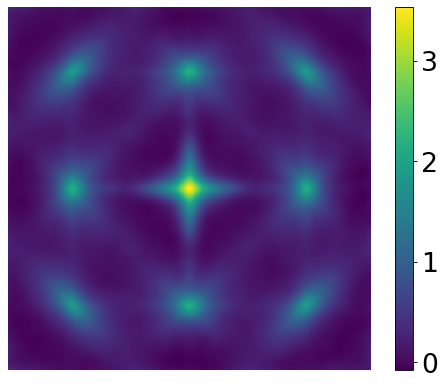

In [26]:
img = np.log10(utils.load_file("data/saeds/Cu_ACC_0_1024.pkl"))
utils.draw_im(compose(blur(sigma=10), slicer)(img))

## Identify peak coordinates

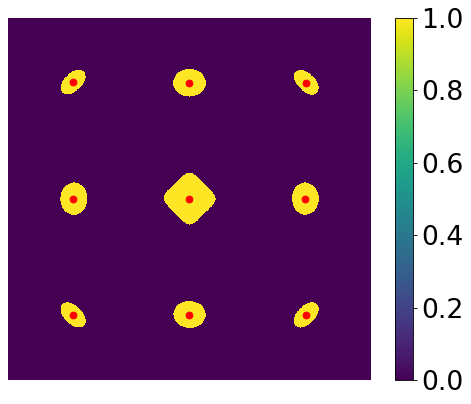

In [27]:
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])
img = utils.load_file(f_saed)
img_log = np.log10(img)


transformer = compose(bool_to_int, opening, erode(selem=np.ones((3,3))), thresh(h=1.0), blur(sigma=20), slicer)

img_t = transformer(img_log)
x_coord, y_coord = get_peak_coords(img_t, size=5)

plt.imshow(img_t)
plt.autoscale(False)
plt.plot(x_coord,y_coord, 'ro')
plt.axis('off')
plt.colorbar()
plt.show()

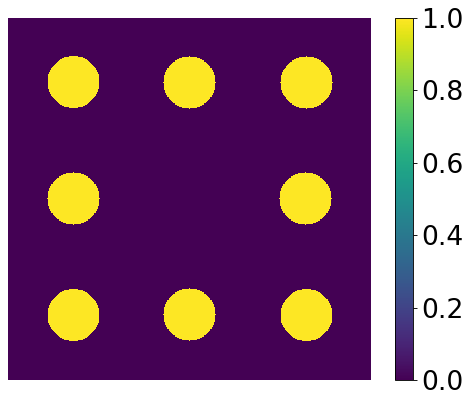

In [29]:
h=701
w = h
r_mask = 50
mask = np.zeros((h, w))
hide_center = True

for ix, _ in enumerate(x_coord):
    mask += create_circular_mask(h, w, radius=r_mask, center=(x_coord[ix], y_coord[ix]))

if hide_center:
    mask *= create_circular_mask(h, w, radius=r_mask) < 1
    
utils.draw_im(mask)

## Apply mask

In [30]:
apply_mask = lambda x: x * mask

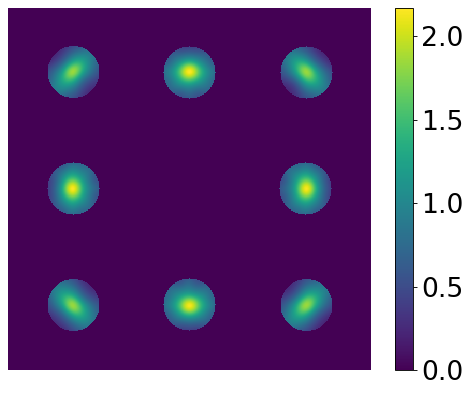

In [31]:
ix = 0
f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, runs[ix])

img_new = compose(apply_mask, blur(sigma=10), slicer, to_log, utils.load_file)(f_saed)
utils.draw_im(img_new)

In [32]:
img_new_list = []
for run in tqdm.tqdm_notebook(runs):
    f_saed = "{}/Cu_ACC_{}_1024_saed.pkl".format(folder_saed, run)
    img_new = compose(apply_mask, blur(sigma=10), slicer, to_log, utils.load_file)(f_saed)
    img_new_list.append(img_new)

In [34]:
utils.save_file("data/saed_masked_imgs_hid.pkl", img_new_list)

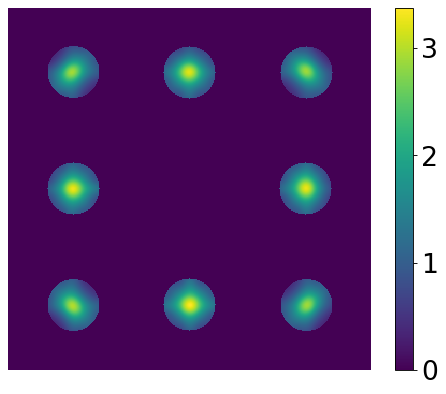

In [33]:
ix = -1
utils.draw_im(img_new_list[ix])

## Compute two-point correlations

In [111]:
from poremks.correlations import compute_statistics

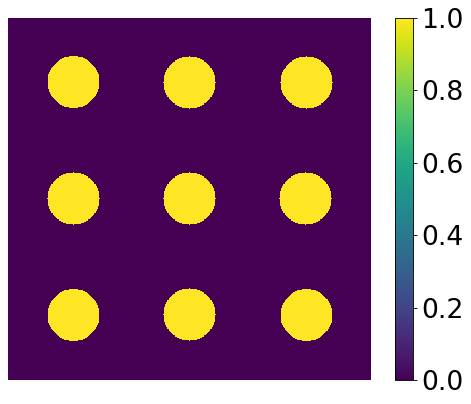

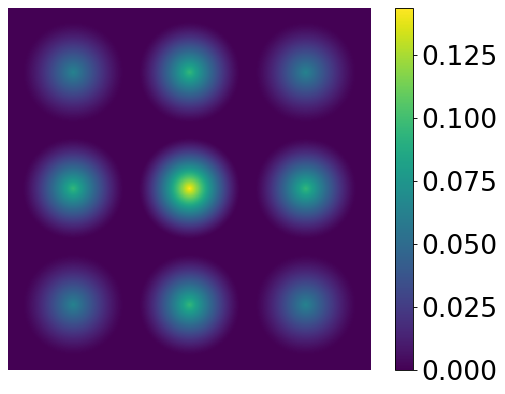

In [121]:
mask_gg = compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=350, device=torch.device("cpu"), args0=mask)
utils.draw_im(mask)
utils.draw_im(mask_gg)

In [126]:
stat_list = []
for new_img in tqdm.tqdm_notebook(img_new_list):
    stat = compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=350, device=torch.device("cpu"), args0=new_img)
    stat_list.append(stat)

In [132]:
utils.save_file("data/saed_masked_imgs.pkl", img_new_list)
# utils.save_file("data/saed_masked_stats.pkl", stat_list)

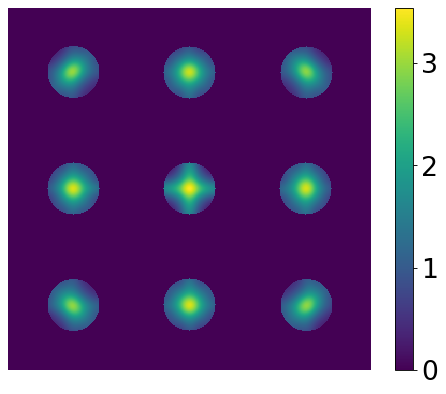

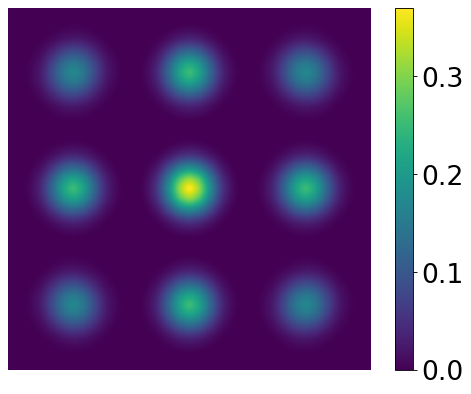

In [130]:
ix = -10
utils.draw_im(img_new_list[ix])
utils.draw_im(stat_list[ix])